In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt

from deep_hedging import (
    Underlyings,
    Ticker,
    ConstantRateCurve,
    EuropeanCall,
)
from deep_hedging.hedger import Hedger
from deep_hedging.monte_carlo import GBMSimulator

RANDOM_SEED = 12

In [40]:
N_PATHS = 100_000
N_STOCKS = 1
TILL_MATURITY = 3.0
N_DAYS = 365 * TILL_MATURITY
RF_RATE = 0.03
STRIKE_LEVEL = 1.0
VOL = 0.2

In [41]:
np.random.seed(RANDOM_SEED)

start = dt.datetime(2019, 1, 1)
end = start + dt.timedelta(days=N_DAYS)

underlyings = Underlyings(
    tickers=[Ticker(f"Stock {i + 1}", f"{i + 1}") for i in range(N_STOCKS)],
    start=start,
    end=end,
    dividends=np.array([0.0] * N_STOCKS),
    means=np.array([RF_RATE] * N_STOCKS),
    var_covar=np.array([VOL**2] * N_STOCKS),
)
underlyings.data

In [42]:
curve = ConstantRateCurve(constant_rate=RF_RATE)

In [43]:
european_call = EuropeanCall(
    underlyings=underlyings,
    yield_curve=curve,
    strike_level=STRIKE_LEVEL,
    start_date=start,
    end_date=end,
)

In [44]:
pricer = GBMSimulator(payoff_function=european_call.payoff, random_seed=RANDOM_SEED)

In [45]:
paths = pricer.get_paths(
    spot=[1.0],
    time_till_maturity=TILL_MATURITY,
    risk_free_rate_fn=curve.get_instant_fwd_rate,
    dividends_fn=lambda t: 0.0,
    var_covar_fn=lambda t: np.array([VOL**2] * len(t)),
    n_paths=N_PATHS,
).squeeze(2)
paths.shape

(100000, 757)

In [46]:
hedger = Hedger(european_call, look_ahead=True)

In [47]:
pnl_hedge, pnl_opt = hedger.simulate(
    bids=paths,
    asks=paths,
    rates_lend=curve(european_call.days_till_maturity) / 365,
    rates_borrow=curve(european_call.days_till_maturity) / 365,
)
pnl_hedge.mean(), pnl_opt.mean()

(0.021178108966897022, 0.19572822393987255)

In [48]:
pnl_hedge

array([-0.18860363, -0.16983011, -0.18267193, ..., -0.17677962,
       -0.15104832,  0.1483478 ])

In [49]:
RF_RATE * european_call.time_till_maturity

0.09

In [69]:
(pnl_opt - pnl_hedge).mean() * np.exp(-RF_RATE * european_call.time_till_maturity)

0.1595267934664807

In [51]:
# pnl_hedge_fix, _, _ = hedger.simulate(
#     bids=paths,
#     asks=paths,
#     rates_lend=curve(european_call.days_till_maturity) / 365,
#     rates_borrow=curve(european_call.days_till_maturity) / 365,
#     weights=np.ones(paths.shape) * european_call.delta()
# )

In [52]:
(np.ones(paths.shape) * european_call.delta()).shape

(100000, 757)

In [53]:
paths.shape

(100000, 757)

In [54]:
pnl_opt.std(), pnl_hedge.std(), (pnl_hedge - pnl_opt).std()

(0.30107502584781826, 0.30562672009191216, 0.00814353512928601)

In [56]:
european_call.price()

array([[0.17899527]])

In [57]:
np.corrcoef(pnl_hedge, pnl_opt)

array([[1.        , 0.99975222],
       [0.99975222, 1.        ]])

In [58]:
(
    pnl_opt - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).mean()

-0.0001238017003800206

In [59]:
(
    pnl_opt - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).std()

0.30107502584781826

In [60]:
(
    pnl_opt
    - pnl_hedge
    - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).std()

0.00814353512928601

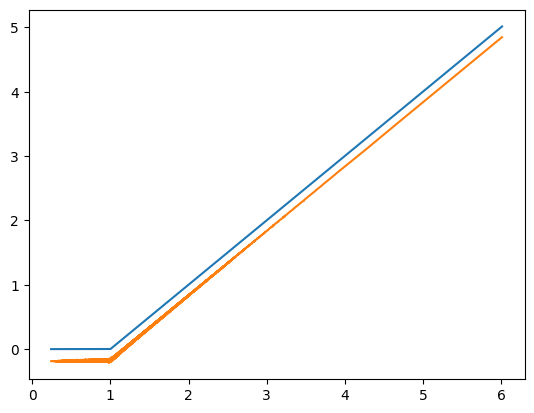

In [61]:
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_hedge[np.argsort(paths[:, -1])])
plt.show()

In [62]:
(pnl_hedge - RF_RATE * european_call.time_till_maturity).mean()

-0.06882189103310299

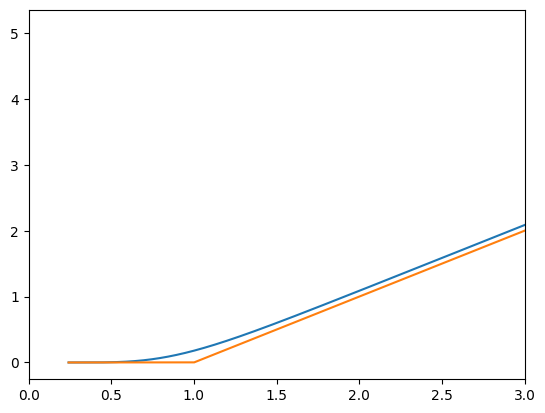

In [63]:
value_opt = european_call.price(spot=paths[:, -1])

plt.plot(np.sort(paths[:, -1]), value_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.xlim([0, 3])
plt.show()

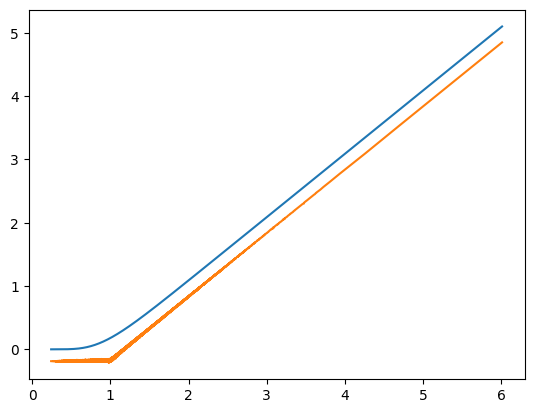

In [64]:
plt.plot(np.sort(paths[:, -1]), value_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_hedge[np.argsort(paths[:, -1])])
plt.show()

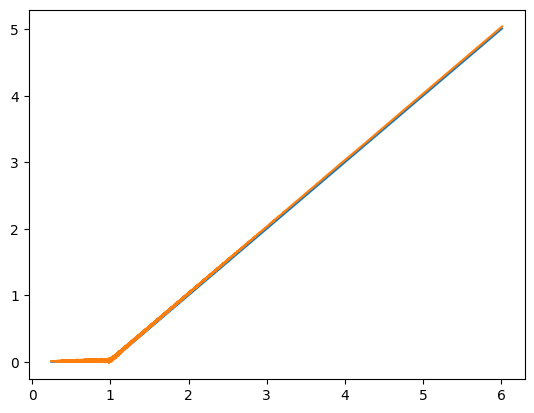

In [65]:
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.plot(
    np.sort(paths[:, -1]),
    pnl_hedge[np.argsort(paths[:, -1])] + european_call.price().T.squeeze(1) * np.exp(RF_RATE * european_call.time_till_maturity),
)
plt.show()

In [66]:
portfolio = pnl_hedge + european_call.price().T.squeeze(1) * np.exp(RF_RATE * european_call.time_till_maturity) - pnl_opt
portfolio.mean(), portfolio.std()

(0.021301910667277053, 0.00814353512928601)

In [67]:
european_call.delta()

array([[0.66749723]])

In [68]:
0.6 * RF_RATE * european_call.time_till_maturity

0.05399999999999999